In [62]:
from pycaret.regression import *
import pandas as pd
from itertools import combinations

path = 'datathon/dataset/product_preprocessed.csv'
path2 = 'datathon/dataset/outfit_preprocessed.csv'

df = pd.read_csv(path)

outfits = pd.read_csv(path2)

In [98]:
import itertools

conteo_parejas = outfits.groupby('cod_outfit')['cod_modelo_color'].apply(lambda x: list(itertools.combinations(x, 2))).explode().value_counts().reset_index(name='cantidad')

print(conteo_parejas)

                            index  cantidad
0      (53091158-OR, 53080809-OR)        81
1      (53090511-CU, 53030691-OR)        74
2      (53090511-CU, 53080809-OR)        74
3      (57023725-09, 57044409-TO)        61
4      (57023725-09, 57010282-01)        57
...                           ...       ...
70254  (57066023-01, 57000342-TC)         1
70255  (57000265-12, 57000345-12)         1
70256  (57000345-12, 57040377-70)         1
70257  (47005943-01, 47005857-OR)         1
70258  (57035922-99, 57995935-52)         1

[70259 rows x 2 columns]


## Merge dels dos productes

In [ ]:
d_0 = pd.read_csv("d_0.csv")

for id_obs in d_0.index:
    obs = d_0.loc[id_obs]
    # print(list(obs))
    l = str(obs["index"]).strip('()').replace("'", "").split(', ')

    i = 1
    for id in l:
        for col in df.columns:
            col_new = col + f"{i}"

            # Crea la columna en conteo_parejas si no existe
            if col_new not in d_0.columns:
                d_0[col_new] = None  # Puedes asignar un valor predeterminado o dejarlo como NaN
                # print(conteo_parejas[col])
            
            val = df[df["cod_modelo_color"] == id][col].values[0]
            d_0.at[id_obs, col_new] = val
        i += 1

Exemples Negatius

In [63]:
d_0 = pd.read_csv("d_0.csv")

for id_obs in d_0.index:
    obs = d_0.loc[id_obs]
    # print(list(obs))
    l = str(obs["index"]).strip('()').replace("'", "").split(', ')

    i = 1
    for id in l:
        for col in df.columns:
            col_new = col + f"{i}"

            # Crea la columna en conteo_parejas si no existe
            if col_new not in d_0.columns:
                d_0[col_new] = None  # Puedes asignar un valor predeterminado o dejarlo como NaN
                # print(conteo_parejas[col])
            
            val = df[df["cod_modelo_color"] == id][col].values[0]
            d_0.at[id_obs, col_new] = val
        i += 1

d_0["cantidad"] = 0

In [ ]:
df2 = pd.concat([conteo_parejas, d_0])

In [155]:
df2.to_csv("merged_dataset_with_neg.csv")

## Pycaret Baselines

In [68]:
path = 'merged_dataset_with_neg.csv'

df = pd.read_csv(path)

In [8]:
s = setup(df.drop("index", axis=1), target = 'cantidad', transform_target = True, log_experiment = True)

,Description,Value
0,Session id,1909
1,Target,cantidad
2,Target type,Regression
3,Original data shape,"(70259, 32)"
4,Transformed data shape,"(70259, 32)"
5,Transformed train set shape,"(49181, 32)"
6,Transformed test set shape,"(21078, 32)"
7,Numeric features,31
8,Preprocess,True
9,Imputation type,simple


2023/11/11 21:50:07 INFO mlflow.tracking.fluent: Experiment with name 'reg-default-name' does not exist. Creating a new experiment.


In [9]:
# Comparar modelos
best_model = compare_models()

# Crear un modelo específico
lr_model = create_model('lr')

# Ajustar el modelo
tuned_lr_model = tune_model(lr_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
dt,Decision Tree Regressor,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0710
rf,Random Forest Regressor,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0520
ada,AdaBoost Regressor,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.3450
gbr,Gradient Boosting Regressor,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.6640
xgboost,Extreme Gradient Boosting,0.0000,0.0000,0.0000,0.9998,0.0000,0.0000,0.3580
et,Extra Trees Regressor,0.0000,0.0000,0.0000,0.9998,0.0000,0.0000,0.8620
knn,K Neighbors Regressor,0.0000,0.0000,0.0000,0.9985,0.0000,0.0000,0.3240
lightgbm,Light Gradient Boosting Machine,0.0000,0.0000,0.0000,0.9973,0.0000,0.0000,0.1540
br,Bayesian Ridge,0.0003,0.0000,0.0004,0.5089,0.0003,0.0022,0.1290
lr,Linear Regression,0.0003,0.0000,0.0004,0.5089,0.0003,0.0022,0.4290


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0003,0.0000,0.0004,0.5241,0.0003,0.0021
1,0.0003,0.0000,0.0004,0.5174,0.0003,0.0021
2,0.0003,0.0000,0.0004,0.5028,0.0003,0.0022
3,0.0003,0.0000,0.0004,0.5175,0.0003,0.0022
4,0.0003,0.0000,0.0004,0.5139,0.0003,0.0021
5,0.0003,0.0000,0.0004,0.5012,0.0003,0.0022
6,0.0003,0.0000,0.0004,0.4929,0.0003,0.0022
7,0.0003,0.0000,0.0004,0.5171,0.0003,0.0021
8,0.0003,0.0000,0.0004,0.5010,0.0003,0.0022


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0003,0.0000,0.0004,0.5241,0.0003,0.0021
1,0.0003,0.0000,0.0004,0.5174,0.0003,0.0021
2,0.0003,0.0000,0.0004,0.5028,0.0003,0.0022
3,0.0003,0.0000,0.0004,0.5175,0.0003,0.0022
4,0.0003,0.0000,0.0004,0.5139,0.0003,0.0021
5,0.0003,0.0000,0.0004,0.5012,0.0003,0.0022
6,0.0003,0.0000,0.0004,0.4929,0.0003,0.0022
7,0.0003,0.0000,0.0004,0.5171,0.0003,0.0021
8,0.0003,0.0000,0.0004,0.5010,0.0003,0.0022


Fitting 10 folds for each of 2 candidates, totalling 20 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


# Neural Network & XGBoost

In [156]:
target_name = "cantidad"

In [157]:
path = 'merged_dataset_with_neg.csv'

df = pd.read_csv(path)

In [158]:
from sklearn.model_selection import train_test_split
from copy import copy
from sklearn.model_selection import train_test_split

def prepare_dataset(df, seed=1):
    X = df.copy()
    
    features_to_drop = [target_name, "cod_modelo_color1", "cod_modelo_color2", "des_filename1", "des_filename2", "index"]
    X.drop(features_to_drop, axis=1, inplace=True)

    X_train, X_temp, y_train, y_temp = train_test_split(X, df[target_name], test_size=0.3, shuffle=True, random_state=seed)
    
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True, random_state=seed)

    return X_train, X_val, X_test, y_train, y_val, y_test

def copy_vars(X_train2=None, X_test2=None, y_train2=None, y_test2=None):
    X_train = X_train2.copy()
    y_train = y_train2.copy()
    X_test = X_test2.copy()
    y_test = y_test2.copy()

    return X_train, X_test, y_train, y_test

In [159]:
from sklearn.linear_model import Perceptron
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from keras.optimizers import SGD, Adamax
import matplotlib.pyplot as plt
from sklearn import metrics
import tensorflow as tf
import numpy as np
import random
from keras import regularizers

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

def train_perceptron(df, lr, mom, batch, pat, epochs=100, X_train2=None, X_test2=None, y_train2=None, y_test2=None, verbose=True):
    tf.random.set_seed(1)
    np.random.seed(1)
    random.seed(1)

    X_train, X_test, y_train, y_test = copy_vars(X_train2, X_test2, y_train2, y_test2)
    
    # sc_X = StandardScaler()
    # X_train = sc_X.fit_transform(X_train)
    # X_test = sc_X.transform(X_test)
    
    # X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=1)
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    # X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # scaler = RobustScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)

    # Create the model
    model = Sequential()

    model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))
    
    # Compile the model
    learning_rate = lr
    sgd = SGD(learning_rate=learning_rate, momentum=mom)
    model.compile(loss='mean_squared_error', optimizer=sgd)

    # Early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=pat, mode='min', verbose=1)

    v = 0

    if verbose:
        v = 1

    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, verbose=v, batch_size=batch, validation_data=(X_test, y_test), callbacks=[early_stop], shuffle=True)

    if verbose:
        # Plot the training and validation loss as a function of epoch
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()


    y_pred = model.predict(X_train)
    print(f"Dataset de Train:")
    print(f"MSE: {metrics.mean_squared_error(y_train, y_pred)}")
    print(f"MAE: {metrics.mean_absolute_error(y_train, y_pred)}")
    print(f"R2: {metrics.r2_score(y_train, y_pred)}\n")

    y_pred = model.predict(X_test)
    print(f"\nDataset de Test:")
    print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
    print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
    print(f"R2: {metrics.r2_score(y_test, y_pred)}\n")

    if v:
        model.summary()

    r2 = metrics.r2_score(y_test, y_pred)
    
    return model, r2

In [160]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import GridSearchCV

def XGboost(df, var="", cv_folds= 2):

    X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(df)

    X_train = X_train.astype(float)
    X_val = X_val.astype(float)
    X_test = X_test.astype(float)

    param_grid = {
        'n_estimators': [250, 600, 800],      # Número de árboles (estimadores) en el modelo
        'learning_rate': [0.01, 0.001], # Tasa de aprendizaje
        'max_depth': [6, 7, 9],              # Profundidad máxima de cada árbol
        'subsample': [0.3, 0.9],             # Proporción de muestras de entrenamiento utilizadas para entrenar cada árbol
        'colsample_bytree': [0.3, 0.9]       # Proporción de características utilizadas para entrenar cada árbol
    }

    model = xgb.XGBRegressor(
        objective='reg:squarederror',  # Para problemas de regresión, también puedes usar 'binary:logistic' para clasificación binaria
        random_state=42,             # Semilla para reproducibilidad
    )

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds, scoring='neg_mean_squared_error', n_jobs=-1)
    
    best_model_fitted = grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    print("Mejores hiperparámetros encontrados:")
    print(best_params)

    y_pred = best_model_fitted.predict(X_train)

    print("Training:")
    print(f"MSE: {metrics.mean_squared_error(y_train, y_pred)}")
    print(f"MAE: {metrics.mean_absolute_error(y_train, y_pred)}")
    print(f"R2: {metrics.r2_score(y_train, y_pred)}\n")

    y_pred = best_model_fitted.predict(X_val)

    print("Validation:")
    print(f"MSE: {metrics.mean_squared_error(y_val, y_pred)}")
    print(f"MAE: {metrics.mean_absolute_error(y_val, y_pred)}")
    print(f"R2: {metrics.r2_score(y_val, y_pred)}\n")

    y_pred = best_model_fitted.predict(X_test)

    print("Testing:")
    print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
    print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
    print(f"R2: {metrics.r2_score(y_test, y_pred)}\n")

    return best_model

In [125]:
df2.drop(["Unnamed: 0"],axis=1,inplace=True)

KeyError: "['Unnamed: 0'] not found in axis"

Index(['R1', 'G1', 'B1', 'des_fabric_C-COMPLEMENTOS1', 'des_fabric_J-JEANS1',
       'des_fabric_K-CIRCULAR1', 'des_fabric_L-PIEL1',
       'des_fabric_O-POLIPIEL1', 'des_fabric_P-PLANA1', 'des_fabric_T-TRICOT1',
       'des_product_category_Accesories, Swim and Intimate1',
       'des_product_category_Bottoms1',
       'des_product_category_Dresses, jumpsuits and Complete set1',
       'des_product_category_Outerwear1', 'des_product_category_Tops1', 'R2',
       'G2', 'B2', 'des_fabric_C-COMPLEMENTOS2', 'des_fabric_J-JEANS2',
       'des_fabric_K-CIRCULAR2', 'des_fabric_L-PIEL2',
       'des_fabric_O-POLIPIEL2', 'des_fabric_P-PLANA2', 'des_fabric_T-TRICOT2',
       'des_product_category_Accesories, Swim and Intimate2',
       'des_product_category_Bottoms2',
       'des_product_category_Dresses, jumpsuits and Complete set2',
       'des_product_category_Outerwear2', 'des_product_category_Tops2'],
      dtype='object')
(63181, 30)
(13539, 30)
(63181,)
(13539,)
Epoch 1/50
247/247 [=====

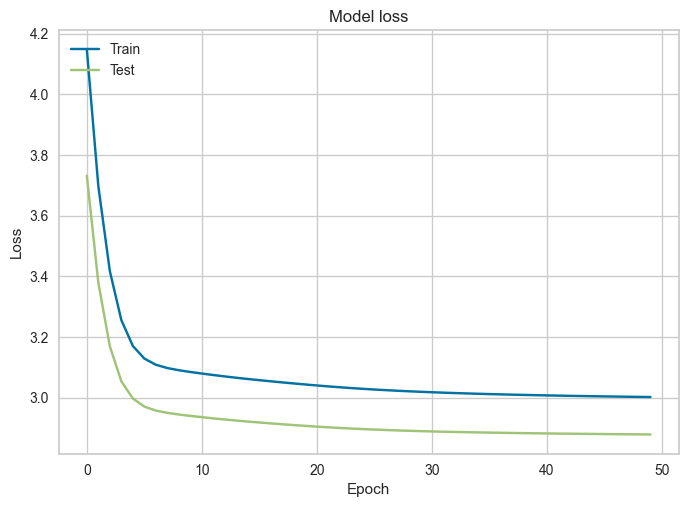

1975/1975 [==============================] - 7s 3ms/step
Dataset de Train:
MSE: 3.002142885860747
MAE: 0.6906993630836893
R2: 0.05842816281510954

424/424 [==============================] - 2s 4ms/step

Dataset de Test:
MSE: 2.8791251806938254
MAE: 0.6891046331775657
R2: 0.05212341548624577

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_84 (Dense)            (None, 256)               7936      
                                                                 
 dense_85 (Dense)            (None, 128)               32896     
                                                                 
 dense_86 (Dense)            (None, 64)                8256      
                                                                 
 dense_87 (Dense)            (None, 32)                2080      
                                                                 
 dense_88 (Dense)       

In [161]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(df2)

print(X_train.columns)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

model, r2 = train_perceptron(df2, epochs=50, lr=0.00001, batch=256, mom=0.9, pat=25, X_train2=X_train, X_test2=X_val, y_train2=y_train, y_test2=y_val, verbose=True)

In [153]:
XGboost_model = XGboost(df2)

Mejores hiperparámetros encontrados:
{'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 600, 'subsample': 0.9}
Training:
MSE: 2.84293134965592
MAE: 0.6579715620801089
R2: 0.10836219471993247

Validation:
MSE: 2.783955705895012
MAE: 0.6636860794214068
R2: 0.08345547333741854

Testing:
MSE: 3.218088985167274
MAE: 0.6647864802765725
R2: 0.0836797529028831

